Connected to ift6758-conda-env (Python 3.11.5)

## Advanced Visualizations: Shot Maps

In this notebook, we will create shot maps for any given NHL team, for a given year and season.

In [1]:
import pandas as pd
import numpy as np

In [2]:
def prepare_df(df):
    
    ## select for non null values
    df = df[(df['RinkSide'].notna())]
    df = df[(df['XCoord'].notna())]
    df = df[(df['YCoord'].notna())]
    
    ## make sure there's not missing value
    df['RinkSide'].notna().all() & df['XCoord'].notna().all()  & df['YCoord'].notna().all()  & df['Team'].notna().all()
    
    ## Correct coordinates for rink side
    df.loc[df['RinkSide'] == 'right', ['XCoord']] *=- 1
    df.loc[df['RinkSide'] == 'right', ['YCoord']] *=- 1
    df['xlabel'] = df['XCoord'].apply(lambda x: int(x))
    df['ylabel'] = df['YCoord'].apply(lambda x: int(x))
    
    return df


def league_avg_shot_rate(df):
    
    ## compute league average shot rate at each location
    df_gamesPerSeason = df[['GameID', 'Season']].drop_duplicates().groupby(['Season']).count()
    df_leagueAverage = df.groupby(['Season', 'xlabel', 'ylabel']).agg({'Event': 'count'})
    merged = df_leagueAverage.merge(df_gamesPerSeason, left_index=True, right_index=True)
    df_leagueAverage['LeagueAverage'] = (merged['Event'] / merged['GameID']) / 2 # there are 2 teams for each game
    
    return df_leagueAverage


def team_avg_shot_rate(df):
    
    ## compute team average shot rate at each location
    df_gamesPerTeam = df[['Season', 'Team', 'GameID']].drop_duplicates().groupby(['Season', 'Team']).agg({'GameID': 'count'})
    
    df_teamAverage = df.groupby(['Season', 'Team', 'xlabel', 'ylabel']).agg({'Event': 'count'}).reset_index()
    merged = df_teamAverage.merge(df_gamesPerTeam, how='left', on=['Season', 'Team'])
    df_teamAverage['TeamAverage'] = merged['Event'] / merged['GameID']
    
    # Group by 'Season', 'Team', 'xlabel', and 'ylabel' and calculate the count of 'Event'
    # team_avg_shot_rate = df.groupby(['Season', 'Team', 'xlabel', 'ylabel'])['Event'].count().reset_index()
    # Rename the 'Event' column to 'LeagueAverage'
    #team_avg_shot_rate = team_avg_shot_rate.rename(columns={'Event': 'LeagueAverage'})
    
    return df_teamAverage


def team_excess(df_team_avg, df_league_avg):

    ## merging each team's average with league average
    df_team_excess=df_team_avg.merge(df_league_avg, how='outer', on=['Season', 'xlabel', 'ylabel'])
    ## compute excess shot rate
    df_team_excess['Excess'] = df_team_excess['TeamAverage'] - df_team_excess['LeagueAverage']
    
    return df_team_excess

In [3]:
def season_team_to_dict(df_team_excess, df_coordinate):

    ## season_team_df with x and y coordinates and excess shot rate
    dict_season_team={}
    
    for season in df_team_excess['Season'].unique().tolist():
        dict_season_team[season]={}
        
        for team in df_team_excess['Team'].unique().tolist():
            df_tmp=df_team_excess[(df_team_excess['Team'] == team) & (df_team_excess['Season'] == season)]
            df_tmp2=df_coordinate.merge(df_tmp[['xlabel', 'ylabel', 'Excess']], how='left', on=['xlabel', 'ylabel'])
            df_tmp2=df_tmp2.fillna(0)
            df_season_team = df_tmp2[df_tmp2['xlabel'] > 0] # filter to keep only the offensive side
            dict_season_team[season][team] = df_season_team
        
    return dict_season_team

In [4]:
# load data
df_tidy = pd.read_csv('tidied_nhl.csv')

# copy data
df = df_tidy.copy()

# Execute functions for data preparation before plotting
df_processed = prepare_df(df)
df_league_avg = league_avg_shot_rate(df_processed)
df_team_avg = team_avg_shot_rate(df_processed)
df_team_excess = team_excess(df_team_avg, df_league_avg)

In [5]:
# creating empty dataframe to store all teams' excess shot rate
dfx = pd.DataFrame({'xlabel': [i for i in range(-99,100)]})
dfx['index'] = 1
dfy = pd.DataFrame({'ylabel': [i for i in range(-42,43)]})
dfy['index'] = 1
df_coordinate = dfx.merge(dfy, on=['index'])

dict_season_team = season_team_to_dict(df_team_excess, df_coordinate)

# Creating the Interactive Shot Map

The plot is interactive with options to select the team and the season. We have only created the offensive zone figures. 

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from scipy.ndimage import gaussian_filter
from scipy.interpolate import griddata
from ipywidgets import interact, interactive, fixed, interact_manual, widgets

In [7]:
def plot_shot_map(year, team, df):
    
    plt.clf()
    
    # Use previously generated data with columns: x coordinates, y coordinates, excess shot rate
    game = df[year][team] 
    
    fig, ax = plt.subplots(figsize=(12,10), facecolor='w', edgecolor='k')
    img = plt.imread('figures/nhl_rink.png')
    ext = [-100, 100, -42.5, 42.5]
    plt.imshow(img, zorder=0, extent=ext, aspect=1)
    
    [x,y] = np.round(np.meshgrid(np.linspace(0, 100, 100), np.linspace(-42.5, 42.5, 85)))
    excess_shot_rate = griddata((game['xlabel'], game['ylabel']), game['Excess'], (x,y), method='cubic', fill_value=0)
    
    # Use kernel density estimation with a Gaussian kernel
    excess_shot_rate = gaussian_filter(excess_shot_rate, sigma=5)
    img = ax.imshow(excess_shot_rate, extent=[0, 100, -42.5, 42.5], origin='lower', cmap='bwr', alpha=0.5 )#, clim=(-1, 1))
    
    cbar = plt.colorbar(img, ax=ax, pad = 0.05)
    cbar.ax.set_ylabel('Excess shots per hour', rotation=270, labelpad=20)
    ax.set_title(f"Shot map of the {team} - {year} season")
    ax.set(xticks=np.linspace(90, 0, 10), yticks=np.linspace(-40, 40, 9))
    
    plt.show()


Dropdown(description='Select a season', options=('2016-2017', '2017-2018', '2018-2019', '2019-2020', '2020-202…

Dropdown(description='Select a team', options=('Anaheim Ducks', 'Arizona Coyotes', 'Boston Bruins', 'Buffalo S…

Button(button_style='success', description='Load new shot map', style=ButtonStyle(), tooltip='Load the selecte…

Loading season 2016-2017 for the Montréal Canadiens...


<Figure size 640x480 with 0 Axes>

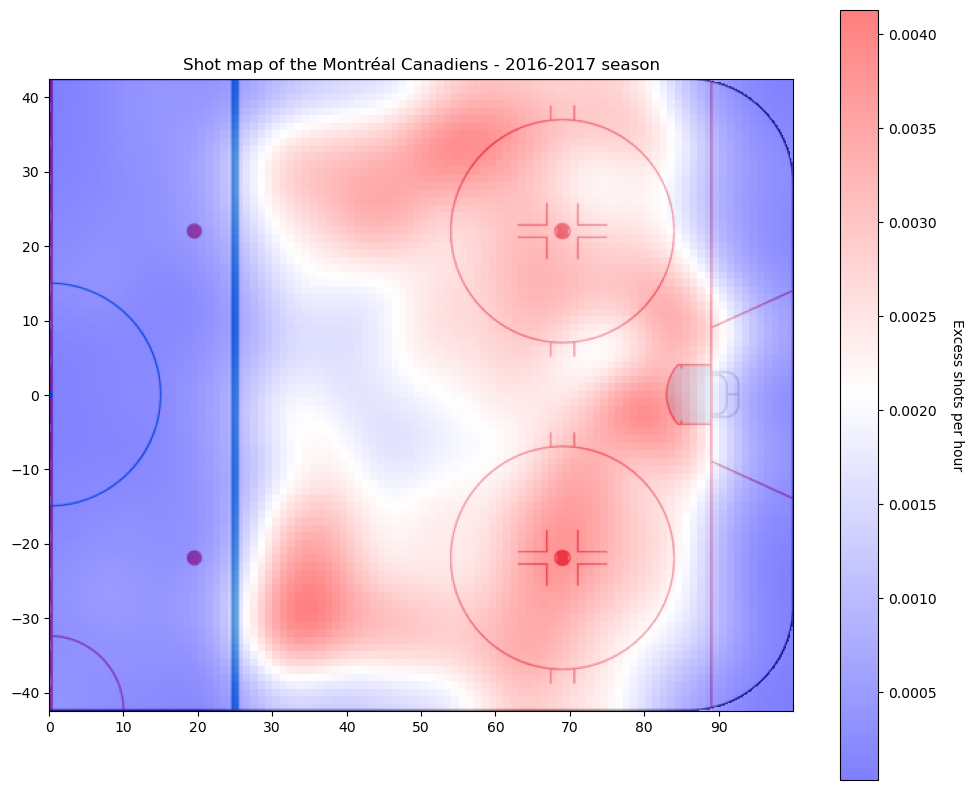

In [8]:
# Update the game based on the selected season and team
def update_game(year, team):
    print(f"Loading season {year} for the {team}...")
    # Simulate shot map data for the game
    plot_shot_map(year, team, dict_season_team)

    
year = widgets.Dropdown(
    options = ['2016-2017', '2017-2018', '2018-2019', '2019-2020', '2020-2021'],
    value = '2016-2017',
    description = 'Select a season',
    disabled = False,
)
team = widgets.Dropdown(
    options=['Anaheim Ducks', 'Arizona Coyotes', 'Boston Bruins', 'Buffalo Sabres',
             'Calgary Flames', 'Carolina Hurricanes', 'Chicago Blackhawks', 'Colorado Avalanche',
             'Columbus Blue Jackets', 'Dallas Stars', 'Detroit Red Wings', 'Edmonton Oilers',
             'Florida Panthers', 'Los Angeles Kings', 'Minnesota Wild', 'Montréal Canadiens',
             'Nashville Predators', 'New Jersey Devils', 'New York Islanders', 'New York Rangers',
             'Ottawa Senators', 'Philadelphia Flyers', 'Pittsburgh Penguins', 'San Jose Sharks',
             'St. Louis Blues', 'Tampa Bay Lightning', 'Toronto Maple Leafs', 'Vancouver Canucks',
             'Vegas Golden Knights', 'Washington Capitals', 'Winnipeg Jets'],
    value='Anaheim Ducks',
    description='Select a team',
    disabled=False,
)

load_button = widgets.Button(
    description='Load new shot map',
    button_style='success',
    tooltip='Load the selected game',
)

def load_game(button):
    year_id = year.value
    team_id = team.value
    update_game(year_id, team_id)

nb_loads = 0
load_button.on_click(load_game)

display(year, team, load_button)
